<h1>Team Info</h1>
<br>
Member_1_Email: Isra.ismail@student.guc.edu.eg <br>
Member_1_Name: Isra Hassan Ali Ragheb ismail<br>
Member_1_ID: 37-0703 <br>
<br>
Member_2_Email: sara.al-labadi@student.guc.edu.eg <br>
Member_2_Name: Sara Mohamed Labadidi<br>
Member_2_ID: 34-10461 <br>
<br>
Member_3_Email: marwa.gaser@student.guc.edu.eg <br>
Member_3_Name: Marwa Abdelrahman Saleh Abdelrahman Gaser<br>
Member_3_ID: 37-10683 <br>
<br>
Member_4_Email: sarah.shaker@student.guc.edu.eg <br>
Member_4_Name: Sarah Ayman Shaker<br>
Member_4_ID: 37-3459<br>

<h1> NLP Project </h1>
<h2 style ="color:blue"> Search Engine and Literature Clustering</h2>
<p>This notebook utilizes two major topics in natural language processing to tackle and answer questions related to COVID-19. The first one is: a <i>search engine</i> which allows the user to enter a query and fetches for them the most relevant papers related to that query (max 5). The other topic is <i>literature clustering</i> where PCA algorithm was used to reduce the dimension of the data, followed by K-means which was used to cluster the papers. This notebook intends to tackle Kaggle's task 1.</p>

In [1]:
# basic libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from tqdm import tqdm
import re #import the regular expression library
import string
import os
import json
import matplotlib.pyplot as plt 

# sklearn libraries used for tfidf and cosine similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import load_files

# nltk libraries for stop word and puncuation removal.
# nltk libraries for word lemmitization
import nltk
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords #import the stopwords from the ntlk.corpus library
nltk.download('stopwords')
from nltk.tokenize import word_tokenize #import the word_tokenize method, which is used to turn sentences into words"
nltk.download('punkt')
from collections import Counter
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# !pip install scispacy scipy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
import en_core_sci_lg  
plt.style.use('ggplot')

from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h4>STEP 1: DATA PREPROCESSING</h4>


<p> Before applying the NLP techniques on the data, data must be preprocessed, cleaned, structured,etc. In the following cell, the folder(s) containing the data in the json format are accessed. Each json file has, then, three majors information extracted from it:<br/>
 <ol>
     <li>The title of the paper</li>
     <li>The abstract of the paper</li>
     <li>The body/full text of the paper</li>
</ol>
These are then added to the list which will contain all the papers with those 3 features or attributes. The list is then converted to a dataframe which will be used later in this notebook.

In [2]:
FullPaper=[]#a list which will save all the papers 
directories = ["biorxiv_medrxiv","noncomm_use_subset","comm_use_subset"] #the folder name which contains the papers
for directory in directories: #for each of the folders carrying the json format of different research papers
    for file in tqdm(os.listdir(f"{directory}/{directory}/pdf_json")): #for every json file
        file_path=f"{directory}/{directory}/pdf_json/{file}" #set the file path to the file_path variable 
        paper = json.load(open(file_path,"rb")) #load the json version of the file
        title = paper['metadata']['title'] #set the title variable to the file's title
        try:
            abstract = paper['abstract']#set the abstract variable to the file's abstract
        except:
            abstarct=""   #set the abstract variable to the an empty string if the file does not have an abstract             
        full_text="" #create an empty string which will hold the body of the paper (file)    
        
        for text in paper['body_text']: #for every word in the body of the file
            full_text += (text['text'] +'\n') #concatenate the word to the variable full_text
        FullPaper.append([title,abstract,full_text]) #since the 3 variable: title, abstract, full_text, now have a value, a paper can be created and added to the FullPaper list
        
FullPaperDataframe=pd.DataFrame(FullPaper,columns=['title','abstract','full_text'])#create a dataframe which will hold all the papers

100%|██████████| 9557/9557 [04:26<00:00, 35.82it/s]


<h5>Data Cleaning</h5>
<p>In the below cell, each body text for each paper is stripped off stop words, punctuation, and is lemmatized. The <i>en_core_sci_lg</i> model was used as it works well on biomedical and scientific papers </p>
<h6 style = "color:green"> PROS Data Cleaning </h6>
<p>Data Cleaning is an essential step in producing high quality data to be further used. By removing stopwords, unnessary puncuations and lemmitization we are able to refine the data avaliable in the dataset to produce high quality results in our project.</p>
<p>We choose to use lemmitization instead of stemming as stemming removes only the suffixes of the word rather than search for its root in a dictionary which is done using lemmtization.</p>
<h6 style = "color:red"> CONS associated with data cleaning </h6>
<p> Some semantic meaning of the data may be lost during the cleaning process.</p>

In [ ]:
import string

full_text = FullPaperDataframe['full_text'].head(2)

clean_text = [] #a list which will hold the clean paper text (after data processing)
dirty_text = []# a list which will hold the dirty paper text (before data processing)
# Intializing parser lemmtizer
lemmatizer = WordNetLemmatizer()

# Using the scispacy library to get the biomedical terms 
parser=en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

# extending and customizing the stopwords list (Since we found these words in the text before adding the our_stopwords list)
all_stopwords = stopwords.words('english')

our_stopwords=['copyright','https','et','al','preprint','preprints',
               'this','these','also','however','although','among','in','medrxiv',
                'biorxiv','license','without','fig','figure','doi','www','author',
                'authors','peerreviewed','review','using','often','the','we','it','they']
all_stopwords.extend(our_stopwords)

pattern = """!"#$%&'()*+,.:;<=>?@[\]^`{|}~"""

#  removing all stop words and extracting puctuations
for val in tqdm(full_text):
    val = val.lower()

    clean_string = re.sub(rf"[{pattern}]", '', val) # Strip punctuation from the text
    clean_string = re.sub(r'\b[a-zA-Z]\b', '', clean_string) # from single letters from the text
    clean_string = re.sub(r'^\d+\s|\s\d+\s|\s\d+$', '', clean_string) #remove digits that aren't associated with a word from the text

    body_tokens = word_tokenize(clean_string)
    body_tokens_dirty = word_tokenize(val)

    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in body_tokens] #removing all punctuation 
    paper_body_without_stopwords =  [token for token in stripped if not token in all_stopwords]#a list which will hold the tokens stripped off stop words and words that aren't pronouns
    dirty_paper_tokens = [token for token in body_tokens_dirty] # will hold the tokens as is

    clean_string = ' '.join(paper_body_without_stopwords) # convert the list into string
    clean_text.append(clean_string)

    dirty_string=' '.join(dirty_paper_tokens) #convert the list of the dirty tokens into a string
    dirty_text.append(dirty_string) #this list will be used later for analysis
lemmatized_text=[]    # a list which will carry the lemmatized text




# applying the parserer on the dataset
for val in tqdm(clean_text):
    lemmatized_string=[]
    words=val.split(' ')
    for word in words:
        if(len(word)>1):
            token = parser(word)
            lemm_token = lemmatizer.lemmatize(token.text)
            lemmatized_string.append(lemm_token)
    if(len(lemmatized_string)>0):
        lemmatized_string = ' '.join(lemmatized_string)
        lemmatized_text.append(lemmatized_string)
    else:
        lemmatized_text.append(" ")
        

 50%|█████     | 1/2 [00:10<00:10, 10.93s/it]

<h5> Corpus Word Count Graph Before Vs. After Data Cleaning </h5>

<p>To demonstrate how effective the data cleaning is, below is a bar chart comparing the corpus word count before and after the data cleaning.</p>

391927869
270579930


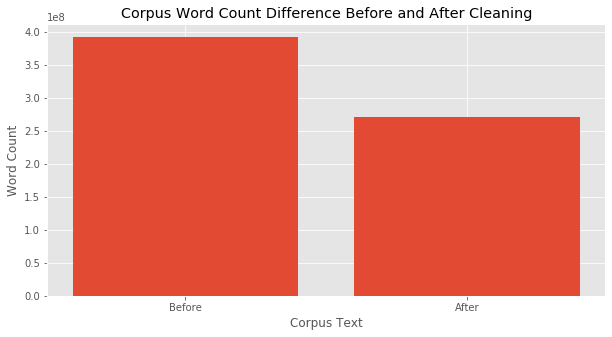

In [23]:
count1=0
count2 =0

for d in dirty_text: #get the word count in all the corpus before preprocessing
    count1 +=len(d)

for st in lemmatized_text:#get the word count in all the corpus after preprocessing
    count2+=len(st)
labels_x=["Before", "After"]
values = [count1, count2]
print(count1)
print(count2)
plt.figure(figsize=(10, 5))
plt.bar(labels_x, values)
plt.xlabel('Corpus Text')
plt.ylabel('Word Count')
plt.title('Corpus Word Count Difference Before and After Cleaning')
plt.show()

<h4>STEP 2: SEARCH ENGINE IMPLEMENTATION</h4>

<h5>TF-IDF</h5>
<p> After the data has been preprocessed, a TF-IDF matrix is to be created. This is a matrix which will hold the values of each word (bag of words of all the corpus) with respect to the document (paper).</p> 
<h6 style = "color:green"> PROS of using tf-idf</h6>
<p>tf-idf matrix considers the unique descriptives words in a corpus and gives them high values. On the contrary, it gives low values to reptitive words in the corpus. Hence, it helps to achieve accurate results for a search engine. </p>
<h6 style = "color:red"> CONS of using tf-idf</h6>
<p>tf-idf matrix does not account for semantics at all, unlike word embeddings, for example.</p>

In [24]:
#create a tf-idf matrix for the words above
v = TfidfVectorizer(min_df = 0.05,max_df = 0.8)
#For the above tf-idf vectorizer:
#The first parameter specifies that if a term appears in less than 5% of the docs, ignore it
#The second parameter, considers word that do not occur in more than 80% of the corpus
tfidf = v.fit_transform(lemmatized_text) #fit and transform the lemmatized texts which were previously cleaned.
#print(sorted(v.vocabulary_.items(), key=lambda x : x[1]))
print(tfidf.toarray())
print(tfidf.shape)

[[0.00122209 0.00486799 0.01890588 ... 0.00665485 0.00633833 0.00115608]
 [0.         0.         0.00489256 ... 0.         0.         0.        ]
 [0.         0.         0.00907523 ... 0.00825238 0.         0.        ]
 ...
 [0.         0.         0.0328655  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01352993 0.         0.02700772 ... 0.0368384  0.02339087 0.02559818]]
(14109, 3219)


<h5>Cosine Similarity</h5>
<p> Cosine similarity is then utilized to get the documents which are closest to the query. The closer the cosine similairty value is to 1, the closer the document is to the query (The more likely it is going to be output). However, for this notebook, we choose to display the top 5 papers with cosine similarity greater than or equal <i>0.1</i>. This number was chosen after several trials to fetch the most relevant papers for different queries.</p>
<h6 style = "color:green"> PROS of using cosine similarity</h6>
<p>Cosine similarity is of a good use, as it can match related documents and queries quite well compared to euclidean distance. Euclidean distance can classify documents and queries as non-similar even if the distribution of terms is significantly alike</p>
<h6> How to run a certain query in the cell?</h6>
<p>Since we have chosen to work on Task 1, please insert any query from the queries related to task 1, in the text field you will get once you run the below cell. For example: <i style = "color:red"> Disease models, including animal models for infection, disease and transmission</i></p>

In [25]:
#Next, the search engine will be implemented with the help of the tf-idf matrix created above and the cosine similarity
flag = False # a flag to indicate whether or not a result is found
pd.set_option('display.max_colwidth', -1)#to avoid dataframe column's data truncation
query = input("Enter your query: ") #get the query from the user
finalQuery="" #create an empty string
words = query.split(' ') #split the query on spaces
for word in words: #for each word in the query
    word = word.lower()
    word = re.sub(rf"[{pattern}]", '', word) # Strip punctuation from the text
    if(word!=""): #if the word is not an empty string
        if (word=="coronaviruses"):#since lemmatize functions do not recognize the word coronaviruses as the plural of coronavirus, a conidition was created
            word ="coronavirus"
        lem_query = lemmatizer.lemmatize(word)#lemmatize the word
        if (lem_query in all_stopwords):
            print("don't add the stop word")
        else:   
            finalQuery+=lem_query+" " #lemmatize the word and concat it to the string finalQuery
query = [finalQuery.strip()]# remove any trailing spaces from the query
query_tfidf = v.transform(query)
cosineSimilarities = cosine_similarity(query_tfidf, tfidf).flatten() #get the cosine similarity list 
#IF NO RESULT
print(cosineSimilarities)
countzero_in2 = np.count_nonzero(cosineSimilarities) #get the number of non zero values in cosine similarity
print(countzero_in2)
if (countzero_in2==0):#if all cosine similarities are 0 (no results)
    flag = True 

else:
    if (countzero_in2>=5):#if there are 5 or more cosine similarities that are greater than 0
        answer_indicies = sorted(range(len(cosineSimilarities)), key=lambda i: cosineSimilarities[i])[-5:] #get the top 5 indices with the highest cosine similarity
    else: #else if they are less than 5, get all of them
        answer_indicies = sorted(range(len(cosineSimilarities)), key=lambda i: cosineSimilarities[i])[-countzero_in2:] #get the top countzero_in2 indices with the highest cosine 

Enter your query: Disease models, including animal models for infection, disease and transmission
don't add the stop word
don't add the stop word
[0.04659719 0.00704735 0.01179262 ... 0.11852504 0.11082234 0.01079936]
13624


[0.46207756758098956, 0.46298594348209166, 0.46433914390989556, 0.47799177237190943, 0.5197484073109556]
[5818, 3547, 6637, 11397, 966]


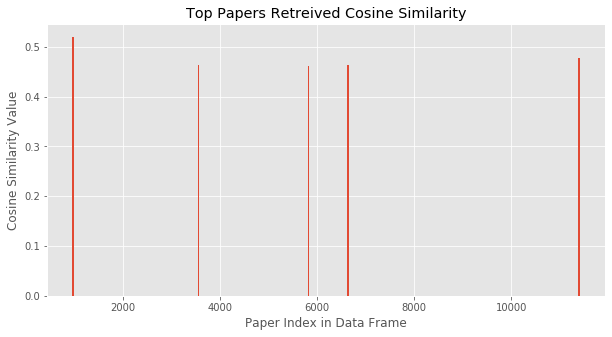

In [26]:
if (flag == False):
    values = [] # a list which will hold the cosine value of each paper outputted
    for i in answer_indicies:
        values.append(cosineSimilarities[i])
    print(values)
    print(answer_indicies)
    plt.figure(figsize=(10, 5))
    plt.bar(answer_indicies, values,width=50)
    plt.xlabel('Paper Index in Data Frame')
    plt.ylabel('Cosine Similarity Value')
    plt.title('Top Papers Retreived Cosine Similarity')
    plt.show()

<p>In the below cell, the code verifies whether or not the cosine similarity is >=0.1, and display the revelant papers, including their abstracts, titles, and full text.</p>

In [27]:
#loop on the top 5 indicies and display the title, abstract, and fulltext of the paper that was fetched from the search
if (flag == True):
    print("Sorry, no results")
else:
    counter =0
    for index in answer_indicies:
        if (cosineSimilarities[index]>=0.1): #get papers with cosine similarities greater than or equal 0.1
            display(FullPaperDataframe.iloc[[index]])
           
           
            
        else:
            counter = counter+1
    if (counter == len(cosineSimilarities)):
        print("Sorry, no results")


Unnamed: 0  Unnamed: 0.1  \
5818  1074.0      1074.0         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 abstract  \
5818  [{'text': 'Background: Dynamic transmission models are increasingly being used to improve our understanding of the epidemiology of healthcare-associated infections (HCAI). However, there has been no recent comprehensive review of this emerging field. This paper summarises how mathematical models have informed the field of HCAI and how methods have developed over time. Methods: MEDLINE, EMBASE, Scopus, CINAHL plus and Global Health databases were systematically searched for dynamic mathematical models of HCAI transmission and/or the dynamics of antimicrobial resistance in healthcare settings. Results: In total, 96 papers met the eligibility criteria. The main research themes considered were evaluation of infection control effectiveness (64%), variability in transmission routes (7%), the impact of movement patterns between healthcare institutes (5%), the development of antimicrobial resistance (3%), and strain competitiveness or cocolonisation with different strains (3%). Methicillin-resistant Staphylococcus aureus was the most commonly modelled HCAI (34%), followed by vancomycin resistant enterococci (16%). Other common HCAIs, e.g. Clostridum difficile, were rarely investigated (3%). Very few models have been published on HCAI from low or middle-income countries. The first HCAI model has looked at antimicrobial resistance in hospital settings using compartmental deterministic approaches. Stochastic models (which include the role of chance in the transmission process) are becoming increasingly common. Model calibration (inference of unknown p

Unnamed: 0  Unnamed: 0.1  \
3547 NaN         NaN             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              abstract  \
3547  [{'text': "Newly available data sets present an exciting opportunity to investigate how human population movement contributes to the spread of infectious diseases across large geographical distances. It is now possible to construct realistic models of infectious disease dynamics for the purposes of understanding global-scale epidemics. Nevertheless, a remaining unanswered question is how best to leverage the new data to parameterize models of movement, and whether one's choice of movement model impacts modeled disease outcomes. We adapt three well-studied models of infectious disease dynamics, the SIR model; the SIS model; and the Ross-Macdonald model, to incorporate either of two candidate movement models. We describe the effect that the choice of movement model has on each disease model's results, finding that in all cases there are parameter regimes where choosing one movement model instead of another has a profound impact on epidemiological outcomes. We further demonstrate the importance of choosing an appropriate movement model using the applied case of malaria transmission and importation on Bioko Island, Equatorial Guinea, finding that one model produces intelligible predictions of R 0 while the other produces nonsensical results.", 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'Mathematical modeling | Infectious disease dynamics | Human population movement | Malaria DT Citron developed the project and carried out the analysis. DL Smith provided guidance and context for the project. CA Guerra provided the data for building the Bioko Island model. SL Wu, JM Henry, HM Sánchez C, and D Dolgert discussed and reviewed the analysis.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                            

Unnamed: 0  Unnamed: 0.1  \
6637  1893.0      1893.0         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             abstract  \
6637  [{'text': 'We review behavioural change models (BCMs) for infectious disease transmission in humans. Following the Cochrane collaboration guidelines and the PRISMA statement, our systematic search and selection yielded 178 papers covering the period 2010-2015. We observe an increasing trend in published BCMs, frequently coupled to (re)emergence events, and propose a categorization by distinguishing how information translates into preventive actions. Behaviour is usually captured by introducing information as a dynamic parameter (76/178) or by introducing an economic objective function, either with (26/178) or without (37/178) imitation. Approaches using information thresholds (29/178) and exogenous behaviour formation (16/178) are also popular. We further classify according to disease, prevention measure, transmission model (with 81/178 population, 6/178 metapopulation and 91/178 individuallevel models) and the way prevention impacts transmission. We highlight the minority (15%) of studies that use any real-life data for parametrization or validation and note that BCMs increasingly use social media data and generally incorporate multiple sources of information (16/178), multiple types of information (17/178) or both (9/178). We conclude that individual-level models are increasingly used and useful to model behaviour changes. Despite recent advancements, we remain concerned that most models are purely theoretical and lack representative data and a validation process.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Unnamed: 0  Unnamed: 0.1  \
11397  653.0       653.0          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   abstract  \
11397  [{'text': 'The aim of the present study is to apply simple ODE models in the area of modeling the spread of emerging infectious diseases and show the importance of model selection in estimating parameters, the basic reproduction number, turning point, and final size. To quantify the plausibility of each model, given the data and the set of four models including Logistic, Gompertz, Rosenzweg, and Richards models, the Bayes factors are calculated and the precise estimates of the best fitted model parameters and key epidemic characteristics have been obtained. In particular, for Ebola the basic reproduction numbers are 1.3522 (95% (95% CI (25630, 25958)), 3916 (95% CI (3865, 3967)), 9886 (95% CI (9740, 10031)), and 12633 (95% CI (12515, 12750)) for West Africa, Guinea, Liberia, and Sierra Leone, respectively. The main results confirm that model selection is crucial in evaluating and predicting the important quantities describing the emerging infectious diseases, and arbitrarily picking a model without any consideration of alternatives is problematic.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Unnamed: 0  Unnamed: 0.1  \
966 NaN         NaN             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        abstract  \
966  [{'text': 'Animal Model Exp Med. 2018;1:247-249.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'wileyonlinelibrary.com/journal/ame2 | 247 mimic the pathological process or symptoms of human diseases, at least partially, should be acknowledged as ideal models. As a result, they believe that comparative medicine is an interdisciplinary subject of Laboratory Animal Science and Medicine, focusing on the similarities and differences in medical proble

<h4>STEP 4: LITERATURE CLUSTERING</h4>

<p>The second part of this notebook attempts to before K-Means clustering on the papers, such that each group of papers related together via certain keywords are grouped together.</p> 
<h6 style = "color:green"> PROS of using K-means</h6>
<p> The pros of using K-means is that many packages provide its functionality and it is easy to implement.</p>
<h6 style = "color:red"> CONS of using K-means</h6>
<p> When clustering a new paper, the distance between that paper and every other paper should be computed, which is time consuming. Besides, the number of clusters which are to be chosen from the optimum cluster number, must be chosen.</p>

<h5>Dimensionality Reduction</h5>
<p>At this stage, we have lots of features/words in the TIF-IDF matrix. However, to allow the K-means to perform better, dimensionality reduction is needed. Therefore, the PCA algorithm is chosen, as it is known that it performs well with K-Means </p>

In [28]:
from sklearn.decomposition import PCA #import PCA which will be used to reduce the dimensions of the dataset

pca = PCA(n_components=0.90,random_state=30)#keep 90% of the variance, and start random centroid @ 30
tf_idf_norm_kmeans= pca.fit_transform(tfidf.toarray())

<h5>Elbow testing </h5>
<p>In order to determine how many clusters are needed for the K-means. A graph is plotted, the point at which the elbow forms is then searched. That value should be used as the number of clusters. </p>

100%|██████████| 16/16 [26:44<00:00, 100.25s/it]


<Figure size 1440x1440 with 0 Axes>

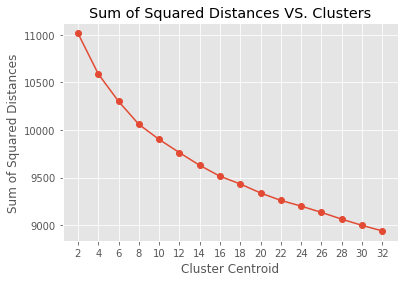

<Figure size 1440x1440 with 0 Axes>

In [30]:
from sklearn.cluster import KMeans #import kmeans which will be used to cluster the data


max_number_of_clusters = 32 #clusters can range from 2-max_number_of_clusters
max_number_of_clusters = max_number_of_clusters+1 # since the range method is exclusive, a 1 should be added.
Ks = range(2, max_number_of_clusters, 2) #Hold the range of clusters k (from 2-max_number_of_clusters)
    
sum_of_squared_distances = [] #a list which will carry the sum of squared distances at each k
for k in tqdm(Ks):
    sum_of_squared_distances.append(KMeans(n_clusters=k,random_state=30).fit(tf_idf_norm_kmeans).inertia_)#calculate the sum of squared distance for each k.
        
  #plot the elbow graph      
f, ax = plt.subplots(1, 1)
ax.plot(Ks, sum_of_squared_distances, marker='o')
ax.set_xlabel('Cluster Centroid')
ax.set_xticks(Ks)
ax.set_xticklabels(Ks)
ax.set_ylabel('Sum of Squared Distances')
ax.set_title('Sum of Squared Distances VS. Clusters')
plt.figure(figsize=(20,20))

<h1 style ="color:blue">The below K is for around 14k papers (all the dataset)</h1>

<h5>Elbow Graph Analysis </h5>
<p>As exhibited in the graph above the elbow forms at k = 28, as the graph starts to level off</p>

In [31]:
optimum_cluster =28

<h5> K-Means clustering</h5>
<p>Now that the number of clusters is known, k-means can be performed as shown in the cell below </p>

In [32]:
clusters = KMeans(n_clusters=optimum_cluster,random_state=30).fit_predict(tf_idf_norm_kmeans) #from the elbow graph we get the n_clusters
df =FullPaperDataframe.copy(deep=True)  #create a new df which will hold the papers attribute along with the cluster number

<p>In the below cell, the cluster to which the paper belongs is added to the dataframe</p>

In [33]:
df['clusters'] = clusters
#save the dataframe
df.to_csv('clusters_df.csv')
df.head() #display the head

Unnamed: 0  Unnamed: 0.1  \
0 NaN         NaN             
1 NaN         NaN             
2 NaN         NaN             
3 NaN         NaN             
4 NaN         NaN             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

<h5>Visualization of clusters</h5>

To get a better sense of the clusters resulting from applying kmeans, we'll plot the clusters.

After applying PCA to the cleaned data, we still have too many dimensions to be able to visualize the clusters. This is why further dimensionality reduction is applied on this highly dimesnional data. We chose to use the TSNE technique on top of PCA.

In [ ]:
from matplotlib.pyplot import cm
from sklearn.manifold import TSNE
#applying TSNE on the tf-idf matrix which had PCA applied to it
tsne = TSNE(random_state=30).fit_transform(tf_idf_norm_kmeans) #choose the random center to be at 30, as we've done in the PCA

f, plot = plt.subplots(1, figsize=(9, 6))

#assigning our own colormap to the plot according to the number of clusters
#since the auto-generated colors were very similar to each other, and the clusters weren't easily distinguished
color = cm.rainbow(np.linspace(0,1,optimum_cluster))

for c in np.unique(clusters):
    ix = np.where(clusters == c)
    plot.scatter(tsne[ix, 0], tsne[ix, 1], c=color[c].reshape(1,-1))

#plot.scatter(tsne[:, 0], tsne[:, 1], c=clusters)      
plot.set_title('Cluster Visualization using TSNE')
plot.set_xlabel('Dimension 1')
plot.set_ylabel('Dimension 2')

The previous plot gives us more insight into how the papers are clustered/grouped. The algorithms used may help us find connections amongst different papers that may have been initially unapparent to us. This can help in the extraction of important information from the papers and advancing research.

Next we apply topic modeling to find the most significant keywords that distinguish the clusters. This will allow us to obtain more meaning about the topics/themes of the different clusters.

<h1>Topic Modeling</h1><br>
Topic Modeling is an unsupervised machine learning technique that tries to discover the abstract "topics" that occur in a collection of documents. Our aim is to apply topic modeling on the set of documents within each cluster to infer the general theme of this cluster.<br>

Group the documents according to their cluster

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

#grouped_docs is a dictionary that holds the docs indices in a cluster eg. {0: [5,20,31], 1: [7,8,11]...}
grouped_docs = df.groupby('clusters').indices

For each set of documents in a cluster:
1. Get the tf-idf matrix 
2. Assume that we only have 2 topics in the cluster and apply the Latent Dirichlet Allocation (LDA) algorithm to find the 10 top words in these topics.

In [19]:
for i in range(0,optimum_cluster):

    current_docs = [lemmatized_text[j] for j in grouped_docs[i]]
    
    # get the tf-idf matrix for the documents within this cluster
    v = TfidfVectorizer(sublinear_tf = True, min_df = 0.05,max_df = 0.8)
    current_tf_idf = v.fit_transform(current_docs)
    feature_names = v.get_feature_names()
    
    # get the top words for 2 topics within each cluster
    lda_model = LatentDirichletAllocation(n_components= 2, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=30)
    lda_model.fit(current_tf_idf)
    lda_model.transform(current_tf_idf)
    
    n_top_words = 10
    print ("cluster {}: ".format(i))
    
    for topic_idx, topic in enumerate(lda_model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]+","
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message[:-1])
    print()

cluster 0: 
Topic #0: prediction, service, pandemic, estimated, admission, inpatient, intensive, coverage, requiring, public
Topic #1: pay, show, scale, model, taken, ability, average, proportion, period, affected

cluster 1: 
Topic #0: virtually, disease, development, induced, vaccine, ab, blot, inducible, genomewide, higher
Topic #1: merscov, injury, human, epithelial, value, measured, gentlemacs, activation, fromcc, gross

cluster 2: 
Topic #0: display, exposed, perpetuity, covid19, period, outbreak, contact, initial, dynamic, reported
Topic #1: granted, perpetuity, asymptomatic, estimate, analysis, different, coronavirus, reported, symptom, estimated

cluster 3: 
Topic #0: number, blood, risk, sarscov2, used, group, normal, pneumonia, rate, effective
Topic #1: lymphocyte, test, described, sample, system, based, acute, wuhan, acid, lower

cluster 4: 
Topic #0: s2, different, sarscov1, reserved, coordinate, protease, molecule, coronavirus, observed, along
Topic #1: outbreak, strong, 

From the above results, We can infer the general theme of a cluster eg. virus transmission, treatments ...etc